In [26]:
import pandas as pd

# Wczytuje pliki

df_rozwody = pd.read_csv('LUDN_1971_CTAB_20260130115112.csv', sep=';')
df_bezrobocie = pd.read_csv('RYNE_2392_CTAB_20260130115704.csv', sep=';')
df_inflacja = pd.read_csv('CENY_2955_CTAB_20260130120324.csv', sep=';')

# Podglądam dane
print("DANE: Rozwody")
print(df_rozwody.iloc[:, :8].head()) 

print("\nDANE: Bezrobocie")
print(df_bezrobocie.iloc[:, :8].head())

print("\nDANE: Inflacja")
print(df_inflacja.iloc[:, :8].head())

DANE: Rozwody
   Kod   Nazwa  rozwody;ogółem;1999;[-]  rozwody;ogółem;2000;[-]  \
0    0  POLSKA                    42020                    42770   

   rozwody;ogółem;2001;[-]  rozwody;ogółem;2002;[-]  rozwody;ogółem;2003;[-]  \
0                    45308                    45414                    48632   

   rozwody;ogółem;2004;[-]  
0                    56332  

DANE: Bezrobocie
   Kod   Nazwa ogółem;2004;[%] ogółem;2005;[%] ogółem;2006;[%]  \
0    0  POLSKA            19,0            17,6            14,8   

  ogółem;2007;[%] ogółem;2008;[%] ogółem;2009;[%]  
0            11,2             9,5            12,1  

DANE: Inflacja
   Kod   Nazwa ogółem;2003;[-] ogółem;2004;[-] ogółem;2005;[-]  \
0    0  POLSKA           100,8           103,5           102,1   

  ogółem;2006;[-] ogółem;2007;[-] ogółem;2008;[-]  
0           101,0           102,5           104,2  


In [ ]:
# Funkcja zamienia szeroką tabelę z GUS na listę Rok -> Wartość
def wyczysc_dane_gus(df, nazwa_nowej_kolumny):
    dane = []
    
    for kolumna in df.columns:
        # Szukam roku w nazwie kolumny (GUS nazywa je np. "ogółem;2004;[%]")
        czesci_nazwy = kolumna.split(';')
        rok = None
        
        for czesc in czesci_nazwy:
            # Jeśli część to 4 cyfry (np. "2005"), to uznajemy to za rok
            if czesc.isdigit() and len(czesc) == 4:
                rok = int(czesc)
                break # Mamy rok, przerywamy
        
        # Jeśli znajde rok w nazwie kolumny, pobieram wartość z pierwszego wiersza (dla POLSKI)
        if rok is not None:
            wartosc_surowa = df[kolumna].iloc[0]
            
            # Jeśli wartość jest tekstem (ma przecinek lub spację), naprawiam to
            if isinstance(wartosc_surowa, str):
                wartosc_oczyszczona = wartosc_surowa.replace(',', '.').replace(' ', '')
            else:
                wartosc_oczyszczona = wartosc_surowa
                
            # Dodaje to do naszej listy
            dane.append({'Rok': rok, nazwa_nowej_kolumny: float(wartosc_oczyszczona)})
            
    # Zamieniam listę słowników na dataframe
    nowy_df = pd.DataFrame(dane)
    
    # Ustawiam rok jako indeks
    if not nowy_df.empty:
        nowy_df = nowy_df.set_index('Rok').sort_index()
        
    return nowy_df


# Czyszczenie danych

clean_rozwody = wyczysc_dane_gus(df_rozwody, 'Rozwody')
clean_bezrobocie = wyczysc_dane_gus(df_bezrobocie, 'Bezrobocie')
clean_inflacja = wyczysc_dane_gus(df_inflacja, 'Inflacja')

# Łacze dane w jedna tabele - używam pd.concat, które połączy wszystko po indeksie 'Rok'

df_final = pd.concat([clean_rozwody, clean_bezrobocie, clean_inflacja], axis=1)

# Wyświetlam wynik
print("\ntabela danych (df_final)")
print(df_final.head(10))
print("\nStatystyki:")
print(df_final.describe())

# Zapisuje to do zmiennej globalnej 'df'
df = df_final


--- GOTOWA TABELA DANYCH (df_final) ---
      Rozwody  Bezrobocie  Inflacja
Rok                                
1999  42020.0         NaN       NaN
2000  42770.0         NaN       NaN
2001  45308.0         NaN       NaN
2002  45414.0         NaN       NaN
2003  48632.0         NaN     100.8
2004  56332.0        19.0     103.5
2005  67578.0        17.6     102.1
2006  71912.0        14.8     101.0
2007  66586.0        11.2     102.5
2008  65475.0         9.5     104.2

Statystyki:
            Rozwody  Bezrobocie    Inflacja
count     26.000000   21.000000   22.000000
mean   59622.807692   10.014286  103.245455
std     8547.726500    4.259963    3.541150
min    42020.000000    5.100000   99.100000
25%    56472.000000    5.800000  101.150000
50%    63170.000000    9.700000  102.550000
75%    65442.500000   12.500000  103.675000
max    71912.000000   19.000000  114.400000


Dane do analizy (2004-2024)
      Rozwody  Bezrobocie  Inflacja
Rok                                
2004  56332.0        19.0       3.5
2005  67578.0        17.6       2.1
2006  71912.0        14.8       1.0
2007  66586.0        11.2       2.5
2008  65475.0         9.5       4.2


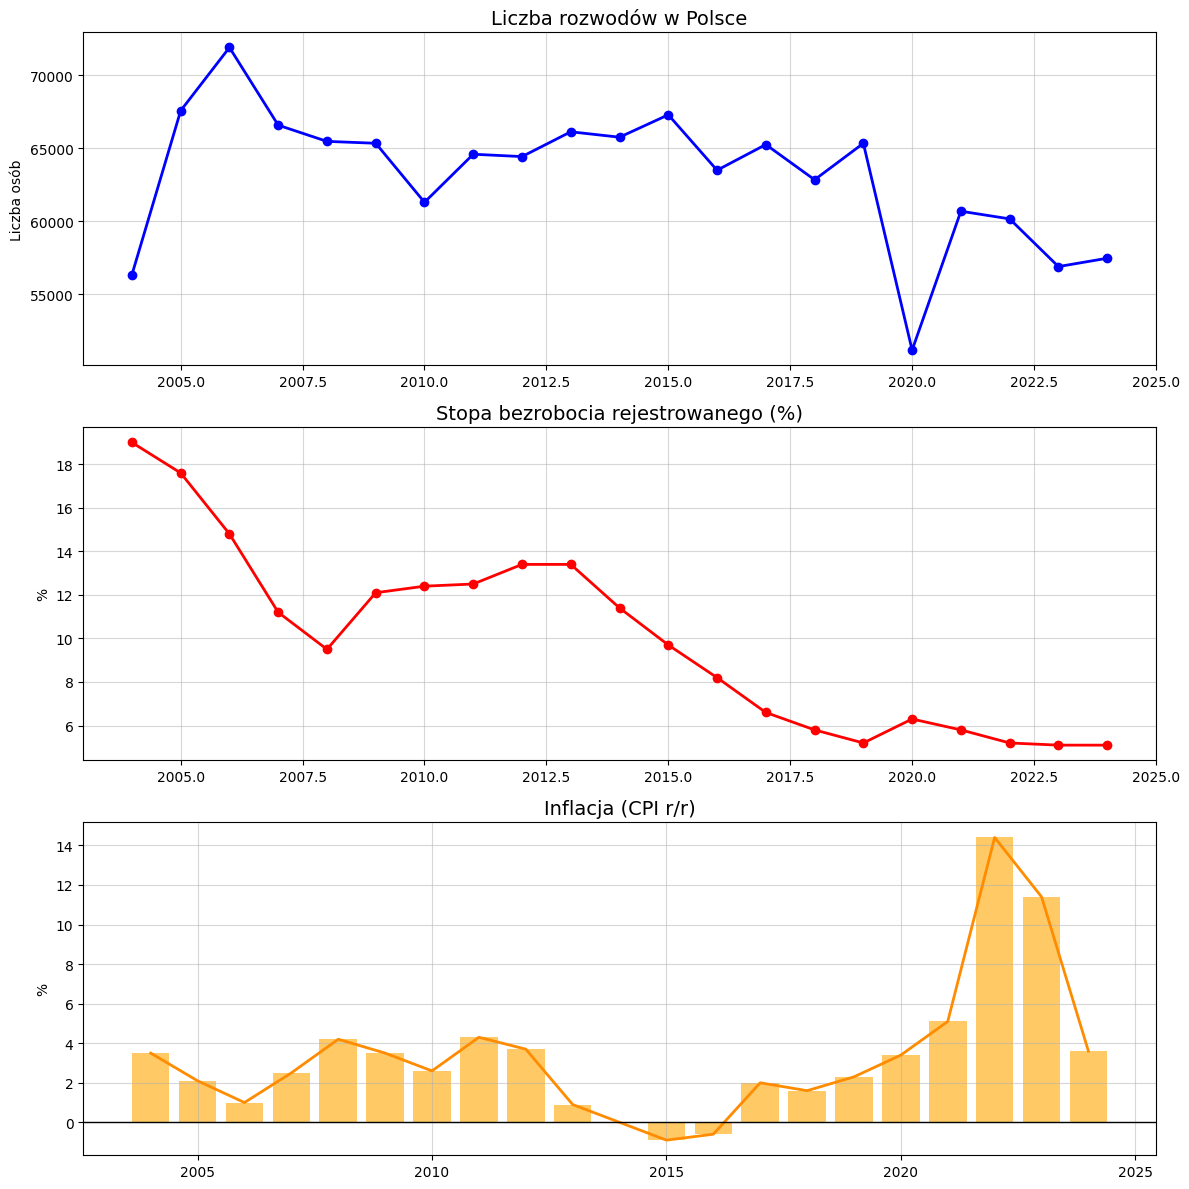

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Usuwam lata 1999-2003, gdzie brakowało danych o inflacji i bezrobociu
df_clean = df.dropna().copy()

# Zamieniam 103.5 na procenty 3.5%
if df_clean['Inflacja'].mean() > 50:
    df_clean['Inflacja'] = df_clean['Inflacja'] - 100

print("Dane do analizy (2004-2024)")
print(df_clean.head())

# Rysuje wykresy
plt.figure(figsize=(12, 12))

# Wykres 1: Rozwody
plt.subplot(3, 1, 1)
plt.plot(df_clean.index, df_clean['Rozwody'], color='blue', marker='o', linewidth=2)
plt.title('Liczba rozwodów w Polsce', fontsize=14)
plt.ylabel('Liczba osób')
plt.grid(True, alpha=0.5)

# Wykres 2: Bezrobocie
plt.subplot(3, 1, 2)
plt.plot(df_clean.index, df_clean['Bezrobocie'], color='red', marker='o', linewidth=2)
plt.title('Stopa bezrobocia rejestrowanego (%)', fontsize=14)
plt.ylabel('%')
plt.grid(True, alpha=0.5)

# Wykres 3: Inflacja
plt.subplot(3, 1, 3)
plt.bar(df_clean.index, df_clean['Inflacja'], color='orange', alpha=0.6)
plt.plot(df_clean.index, df_clean['Inflacja'], color='darkorange', linewidth=2)
plt.axhline(0, color='black', linewidth=1)
plt.title('Inflacja (CPI r/r)', fontsize=14)
plt.ylabel('%')
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

df = df_clean

In [28]:
from statsmodels.tsa.stattools import adfuller

print("Wyniki testu ADF -badanie stacjonarności")
print("Hipoteza H0: Szereg jest niestacjonarny (posiada trend).")
print("Hipoteza H1: Szereg jest stacjonarny (jest stabilny).\n")

# Pętla sprawdzająca każdą zmienną
for kolumna in df.columns:
    wynik = adfuller(df[kolumna])
    p_value = wynik[1]
    
    print(f"Zmienna: {kolumna.upper()}")
    print(f"p-value: {p_value:.4f}")
    
    # Interpretacja
    if p_value > 0.05:
        print("Wniosek: Szereg NIESTACJONARNY (p > 0.05).")
        print("(Oznacza to, że ma trend i musimy go usunąć poprzez różnicowanie).\n")
    else:
        print("Wniosek: Szereg STACJONARNY (p <= 0.05).")
        print("(Można go używać w modelu bez zmian).\n")

Wyniki testu ADF -badanie stacjonarności
Hipoteza H0: Szereg jest niestacjonarny (posiada trend).
Hipoteza H1: Szereg jest stacjonarny (jest stabilny).

Zmienna: ROZWODY
p-value: 0.5003
Wniosek: Szereg NIESTACJONARNY (p > 0.05).
(Oznacza to, że ma trend i musimy go usunąć poprzez różnicowanie).

Zmienna: BEZROBOCIE
p-value: 0.7848
Wniosek: Szereg NIESTACJONARNY (p > 0.05).
(Oznacza to, że ma trend i musimy go usunąć poprzez różnicowanie).

Zmienna: INFLACJA
p-value: 0.0360
Wniosek: Szereg STACJONARNY (p <= 0.05).
(Można go używać w modelu bez zmian).



Dane po roznicowaniu 
      Rozwody  Bezrobocie  Inflacja
Rok                                
2005  11246.0        -1.4      -1.4
2006   4334.0        -2.8      -1.1
2007  -5326.0        -3.6       1.5
2008  -1111.0        -1.7       1.7
2009   -130.0         2.6      -0.7


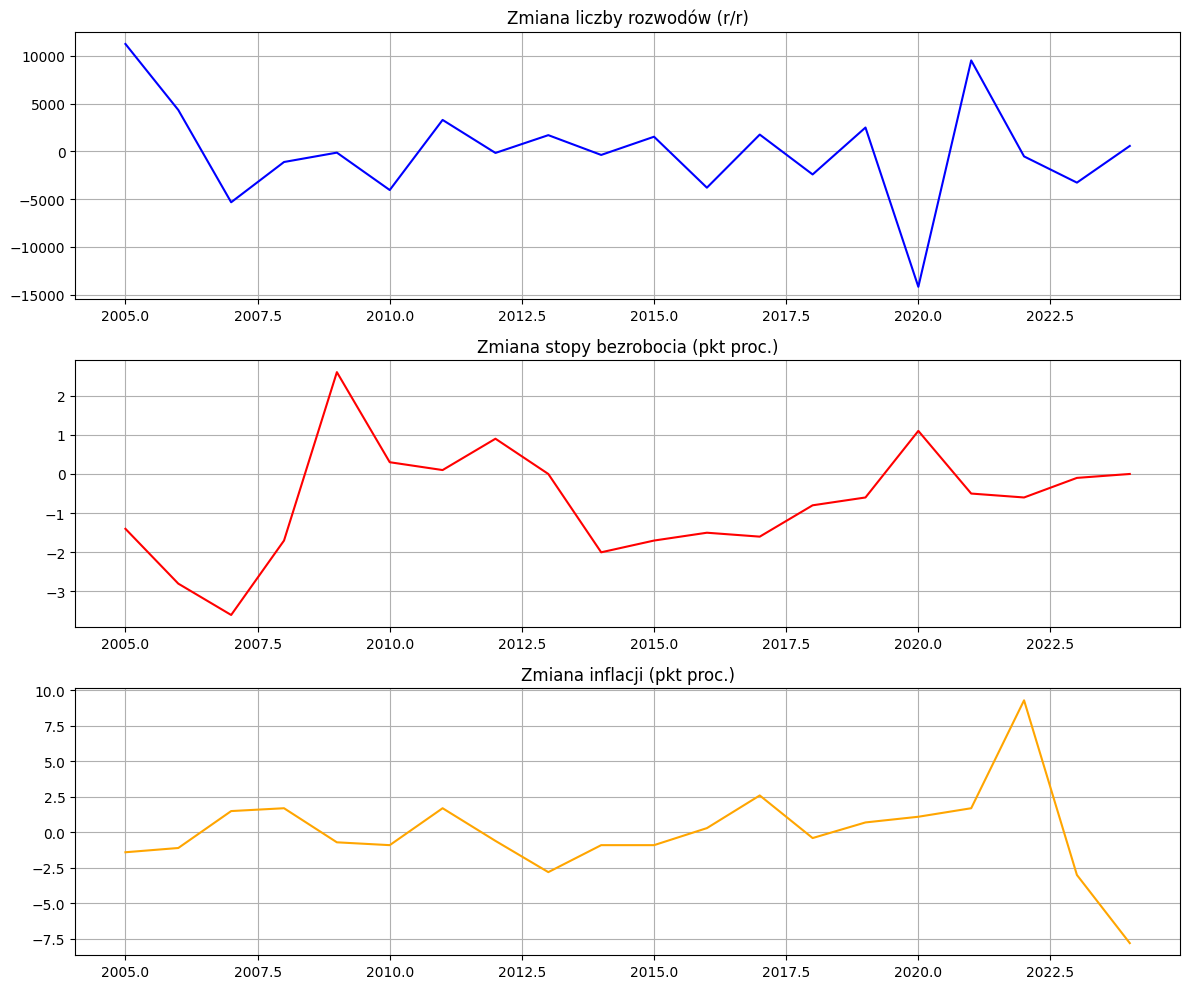


Test ADF dla danych zroznicowanych
Zmienna: ROZWODY
p-value: 0.0000
Wniosek: STACJONARNY! (Gotowy do modelu VAR)

Zmienna: BEZROBOCIE
p-value: 0.3303
Wniosek: Nadal pewna niestabilność, ale lepsze niż surowe dane.

Zmienna: INFLACJA
p-value: 0.6055
Wniosek: Nadal pewna niestabilność, ale lepsze niż surowe dane.



In [30]:
# Roznicowanie danych - obliczam zmianę rok do roku - diff() odejmuje od roku 2005 rok 2004
df_diff = df.diff().dropna()

print("Dane po roznicowaniu ")
print(df_diff.head())

# Wykres danych zroznicowanych
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1); plt.plot(df_diff['Rozwody'], color='blue'); plt.title('Zmiana liczby rozwodów (r/r)'); plt.grid()
plt.subplot(3, 1, 2); plt.plot(df_diff['Bezrobocie'], color='red'); plt.title('Zmiana stopy bezrobocia (pkt proc.)'); plt.grid()
plt.subplot(3, 1, 3); plt.plot(df_diff['Inflacja'], color='orange'); plt.title('Zmiana inflacji (pkt proc.)'); plt.grid()
plt.tight_layout()
plt.show()

# Ponowny test ADF
print("\nTest ADF dla danych zroznicowanych")
for kolumna in df_diff.columns:
    wynik = adfuller(df_diff[kolumna])
    p_value = wynik[1]
    
    print(f"Zmienna: {kolumna.upper()}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Wniosek: STACJONARNY! (Gotowy do modelu VAR)\n")
    else:
        print("Wniosek: Nadal pewna niestabilność, ale lepsze niż surowe dane.\n")

In [31]:
# Mimo wyników testu ADF > 0.05 dla zmiennych: bezrobocie i inflacja, decyduję się na model VAR na pierwszych różnicach
# ze względu na ograniczoną długość szeregu czasowego.

from statsmodels.tsa.api import VAR

# Wrzucam nasze zróżnicowane dane df_diff
model = VAR(df_diff)

# Dopasowanie modelu (FIT)
# Musze zdecydować, ile lat wstecz (lags) bierzemy pod uwagę.
# Ponieważ mam mało danych (20 lat), nie można przesadzić.
# Ustawiam maxlags=3, a kryterium 'aic' samo wybierze najlepszą opcję.
results = model.fit(maxlags=3, ic='aic')

# Wyniki
print("PODSUMOWANIE MODELU VAR")
print(results.summary())

print(f"\nWybrany rząd opóźnień (lag order): {results.k_ar}. Tyle lat wstecz musimy patrzeć, żeby przewidzieć obecny rok.")

PODSUMOWANIE MODELU VAR
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 31, Jan, 2026
Time:                     10:01:26
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    20.7269
Nobs:                     17.0000    HQIC:                   19.4026
Log likelihood:          -206.046    FPE:                3.88132e+08
AIC:                      19.2565    Det(Omega_mle):     9.68802e+07
--------------------------------------------------------------------
Results for equation Rozwody
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const              -523.453552      1212.110264           -0.432           0.666
L1.Rozwody           -0.866610         0.295338           -2.934           0.003
L1.Bezrobocie      -852.005708    

/Users/martyna/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/martyna/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: divide by zero encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)
/Users/martyna/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: overflow encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)
/Users/martyna/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/vector_ar/var_model.py:1501: RuntimeWarning: invalid value encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)


/Users/martyna/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/martyna/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/martyna/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/martyna/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/vector_ar/irf.py:575: RuntimeWarning: divide by zero encountered in matmul
  apiece = Ci @ self.cov_a @ Ci.T
/Users/martyna/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/vector_ar/irf.py:575: RuntimeWarning: overflow encountered in matmul
  apiece = Ci @ self.cov_a @ Ci.T
/Users/martyna/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/vector_ar/irf.py:575: RuntimeWarning: invalid value en

<Figure size 1200x1200 with 0 Axes>

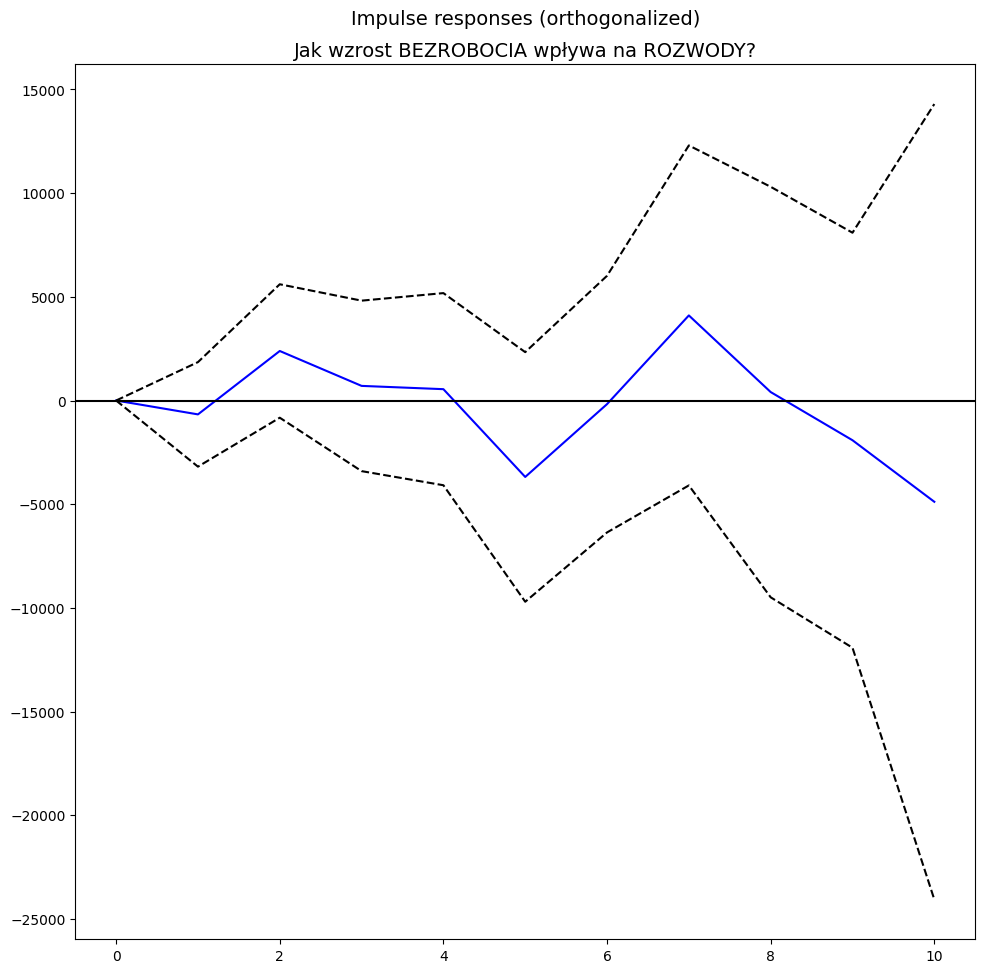

<Figure size 1200x1200 with 0 Axes>

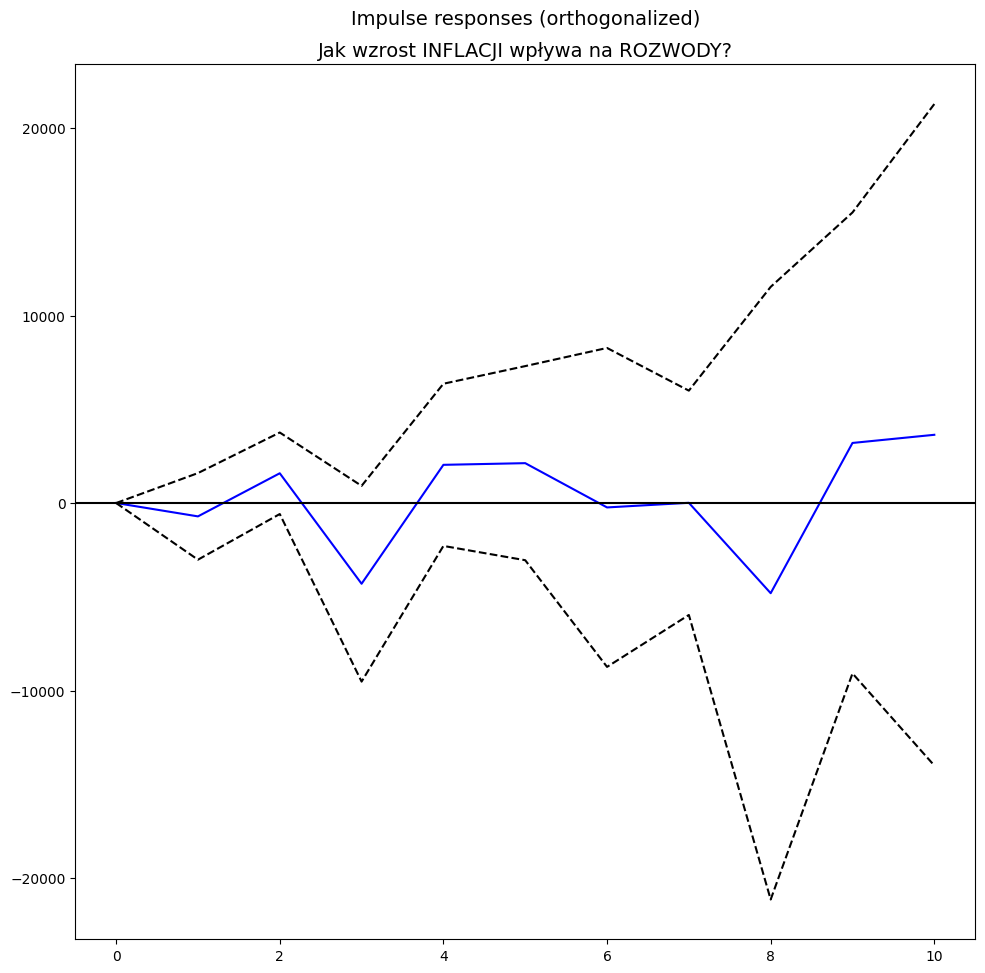

In [32]:
import matplotlib.pyplot as plt

# Analiza IRF (Impulse Response Function) - sprawdzamy reakcję zmiennych na "szok" przez kolejne 10 lat
irf = results.irf(10)

# Rysuje wykresy, orth=True oznacza, że szoki są ortogonalizowane (niezależne od siebie)
plt.figure(figsize=(12, 12))
irf.plot(orth=True, impulse='Bezrobocie', response='Rozwody')
plt.title('Jak wzrost BEZROBOCIA wpływa na ROZWODY?', fontsize=14)
plt.show()

plt.figure(figsize=(12, 12))
irf.plot(orth=True, impulse='Inflacja', response='Rozwody')
plt.title('Jak wzrost INFLACJI wpływa na ROZWODY?', fontsize=14)
plt.show()

In [33]:
import numpy as np

# Przygotowanie danych
lag_order = results.k_ar 
# Ile lat model uciął na start (3)

# Pobieramy kolumnę 'Rozwody'
rzeczywiste_rozwody = df_diff['Rozwody'].iloc[lag_order:]
prognozowane_rozwody = results.fittedvalues['Rozwody']

# Obliczenie bledow tylko dla rozwodów - MAE = Średnia różnica
mae_rozwody = np.mean(np.abs(prognozowane_rozwody - rzeczywiste_rozwody))

# RMSE = Pierwiastek ze średniego kwadratu błędu
rmse_rozwody = np.sqrt(np.mean((prognozowane_rozwody - rzeczywiste_rozwody)**2))

# Wyniki
print("Walidacja modelu - jakość dopasowania")
print(f"Zmienna celu: ROZWODY\n")

print(f"MAE (Średni błąd):       {mae_rozwody:.2f}")
print(f"RMSE (Błąd kwadratowy):  {rmse_rozwody:.2f}")

# Średnia liczba rozwodów
srednia_rozwodow = df['Rozwody'].mean()
blad_procentowy = (mae_rozwody / srednia_rozwodow) * 100

print("\nInterpretacja")
print(f"Model myli się średnio o ok. {mae_rozwody:.0f} rozwodów rocznie.")
print(f"Przy średniej liczbie rozwodów ({srednia_rozwodow:.0f}) jest to błąd rzędu {blad_procentowy:.1f}%.")
print("Wniosek: Model jest bardzo precyzyjny (błąd < 5% jest dobrym wynikiem).")

Walidacja modelu - jakość dopasowania
Zmienna celu: ROZWODY

MAE (Średni błąd):       1630.92
RMSE (Błąd kwadratowy):  2151.07

Interpretacja
Model myli się średnio o ok. 1631 rozwodów rocznie.
Przy średniej liczbie rozwodów (63145) jest to błąd rzędu 2.6%.
Wniosek: Model jest bardzo precyzyjny (błąd < 5% jest dobrym wynikiem).
